In [1]:
#Reference:https://github.com/huyouare/CS231n/blob/master/assignment2/cs231n/layers.py
import numpy as np
import edf
from time import time
import sys
import matplotlib.pyplot as plt

data = np.load('./c10_data/train.npz')
t_imgs = np.float32(data['imgs'])/255.

t_imgs = t_imgs.reshape(50000, 32, 32, 3)
t_labels = np.float32(data['labels'])
#t_imgs = t_imgs[0:500,:,:,:]
#t_labels = t_labels[0:500]

data = np.load('./c10_data/test.npz')
v_imgs = np.float32(data['imgs'])/255.

# Reshape the valid image data to (idx, h, w, channel)
v_imgs = v_imgs.reshape(10000, 32, 32, 3)
v_labels = np.float32(data['labels'])
#v_imgs = v_imgs[0:100,:,:,:]
#v_labels = v_labels[0:100]

In [2]:
import cython

In [3]:
########################################### Convolution layer#############################################
############################### Please implement the forward abd backward method in this class ############## 
class Conv:
    def __init__(self,f,k,stride=1,pad=0):
        edf.components.append(self)
        self.f = f
        self.k = k
        pad = np.array(pad)
        if pad.shape == ():
            self.xpad = self.ypad = pad
        else:
            self.ypad = pad[0]
            self.xpad = pad[1]
            
        self.stride=stride
        self.grad = None if f.grad is None and k.grad is None else edf.DT(0) 

    ####################### Please implement this function####################### 
    @cython.boundscheck(False)
    def forward(self):
        (B, H, W, C) = self.f.value.shape
        (K, _, _, Cprime) = self.k.value.shape
        out_H = int((H+2*self.xpad-K)/self.stride+1)
        out_K = int((W+2*self.ypad-K)/self.stride+1)
                    
        f_pad = np.pad(self.f.value, ((0,0),(self.xpad,self.xpad),(self.ypad,self.ypad),(0,0)), 'constant')
        
        self.f_pad = f_pad
        self.value = np.zeros((B,out_H,out_K,Cprime))
        
        for i in range(out_H):
            for j in range(out_K):
                istart = self.stride*i
                iend = self.stride*i+K
                jstart = self.stride*j
                jend = self.stride*j + K

                window = f_pad[:,istart:iend,jstart:jend,:]
                self.value[:,i,j,:]=np.einsum('bijc,ijcd->bd',window,self.k.value)
       
       
    ####################### Please implement this function#######################         
    @cython.boundscheck(False)
    def backward(self):
        (K, _, _, Cprime) = self.k.value.shape
        (B, out_H, out_W, Cprime) = self.grad.shape
        if self.f.grad is not None:
            df = np.zeros_like(self.f.value)
            for i in range(out_H):
                for j in range(out_W):
                    istart = self.stride*i
                    iend = self.stride*i+K
                    jstart = self.stride*j
                    jend = self.stride*j + K
                    
                    window = np.tile(self.grad[:,i,j,:].reshape(B,1,1,Cprime),(1,K,K,1))
                    df[:,istart:iend,jstart:jend,:] += np.einsum('bijc,ijdc->bijd',window,self.k.value)
            self.f.grad += df

        if self.k.grad is not None:
            for i in range(out_H):
                for j in range(out_W):
                    istart = self.stride*i
                    iend = self.stride*i+K
                    jstart = self.stride*j
                    jend = self.stride*j + K
                    
                    window = self.f_pad[:,istart:iend,jstart:jend,:]
                    dk = np.tile(self.grad[:,i,j,:].reshape((B,1,1,Cprime)),(1,K,K,1))
                    self.k.grad += np.einsum('bijc,bijd->ijdc',dk,window) / B

########################################### MaxPool layer#############################################
############################### Please implement the forward abd backward method in this class ##############             
class MaxPool:
    def __init__(self,x,ksz=2,stride=None):
        edf.components.append(self)
        self.x = x
        self.ksz=ksz
        if stride is None:
            self.stride=ksz
        else:
            self.stride=stride
        self.grad = None if x.grad is None else edf.DT(0)

    ####################### Please implement this function#######################     
    def forward(self):
        (B, H, W, C) = self.x.value.shape
        out_H = int(H / self.ksz)
        out_W = int(W / self.ksz)
        
        self.value = np.zeros((B, out_H , out_W , C))
        self.cache = np.zeros_like(self.x.value)
        
        for i in range(out_H):
            for j in range(out_W):
                
                istart = self.stride*i
                iend = self.stride*i + self.ksz
                jstart = self.stride*j
                jend = self.stride*j + self.ksz
                    
                window=self.x.value[:,istart:iend,jstart:jend,:]
                self.value[:,i,j,:] = np.max(window, axis = (1,2))
                window_ = np.tile(self.value[:,i,j,:].reshape([B,1,1,C]),(1, self.ksz,self.ksz, 1))
                self.cache[:,istart:iend,jstart:jend,:] = (window == window_) #save the mask

    ####################### Please implement this function#######################             
    def backward(self):
        (B, H, W, C) = self.x.value.shape
        (_, out_H, out_W, _) = self.value.shape
        #if self.x.grad is not None:

        if self.x.grad is not None:

            dx = np.zeros_like(self.x.value)
            for i in range(out_H):
                for j in range(out_W):
                    
                    istart = self.stride*i
                    iend = self.stride*i + self.ksz
                    jstart = self.stride*j
                    jend = self.stride*j + self.ksz
                    
                    window = self.cache[:,istart:iend,jstart:jend,:]
                    dx_blob = np.tile(self.grad[:,i,j,:].reshape([B,1,1,C]), (1,self.ksz,self.ksz,1))
                    dx[:,istart:iend,jstart:jend,:] = dx_blob * window
            self.x.grad += dx
########################################### AvePool layer#############################################
############################### Please implement the forward abd backward method in this class ##############                             
class AvePool:
    def __init__(self,x,ksz=2,stride=None):
        edf.components.append(self)
        self.x = x
        self.ksz=ksz
        if stride is None:
            self.stride=ksz
        else:
            self.stride=stride
        self.grad = None if x.grad is None else edf.DT(0)
        
    ####################### Please implement this function#######################   
    def forward(self):
        (B, H, W, C) = self.x.value.shape
        out_H = int(H/self.stride)
        out_W = int(W/self.stride)
        
        self.value = np.zeros((B, out_H, out_W, C))
        
        for i in range(out_H):
            for j in range(out_W):
                istart = self.stride*i
                iend = self.stride*i + self.ksz
                jstart = self.stride*j
                jend = self.stride*j + self.ksz

                window = self.x.value[:,istart:iend,jstart:jend,:]
                self.value[:,i,j,:] = np.average(window, axis = (1,2))
                

                       
                
    ####################### Please implement this function#######################    
    def backward(self):
        if self.x.grad is not None:
            (B,H,W,C) = self.x.value.shape
            out_H = int(H/self.stride)
            out_W = int(W/self.stride)
            
            dx = np.zeros_like(self.x.value)
            
            for i in range(out_H):
                for j in range(out_W):
                    istart = self.stride*i
                    iend = self.stride*i + self.ksz
                    jstart = self.stride*j
                    jend = self.stride*j + self.ksz
                
                    window = np.tile(self.grad[:,i,j,:].reshape([B,1,1,C]), (1,self.ksz,self.ksz,1)) 
                    dx[:,istart:iend,jstart:jend,:] = window / (self.ksz ** 2)
            
            self.x.grad += dx


Entering Evaluation
Entering Train
0
10000
20000
30000
40000
Epoch 0: train loss = 1.9341 [695.821 secs]
test accuracy = 0.3110
0
10000
20000
30000
40000
Epoch 1: train loss = 1.8647 [697.350 secs]
test accuracy = 0.3425
0
10000
20000
30000
40000
Epoch 2: train loss = 1.8120 [696.457 secs]
test accuracy = 0.3567
0
10000
20000
30000
40000
Epoch 3: train loss = 1.7502 [697.801 secs]
test accuracy = 0.3695
0
10000
20000
30000
40000
Epoch 4: train loss = 1.7170 [697.772 secs]
test accuracy = 0.3842
0
10000
20000
30000
40000
Epoch 5: train loss = 1.6920 [697.850 secs]
test accuracy = 0.3950
0
10000
20000
30000
40000
Epoch 6: train loss = 1.6705 [697.818 secs]
test accuracy = 0.3940
0
10000
20000
30000
40000
Epoch 7: train loss = 1.6420 [697.805 secs]
test accuracy = 0.4137
0
10000
20000
30000
40000
Epoch 8: train loss = 1.6195 [697.788 secs]
test accuracy = 0.4294
0
10000
20000
30000
40000
Epoch 9: train loss = 1.6087 [698.618 secs]
test accuracy = 0.4266


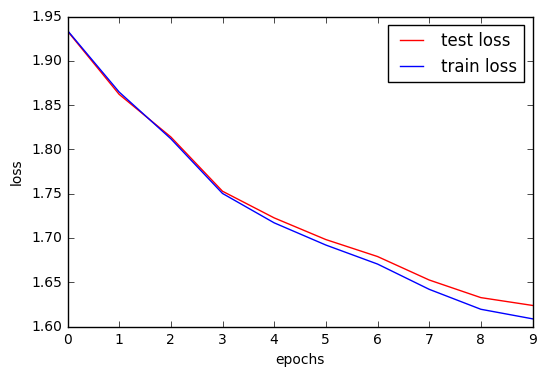

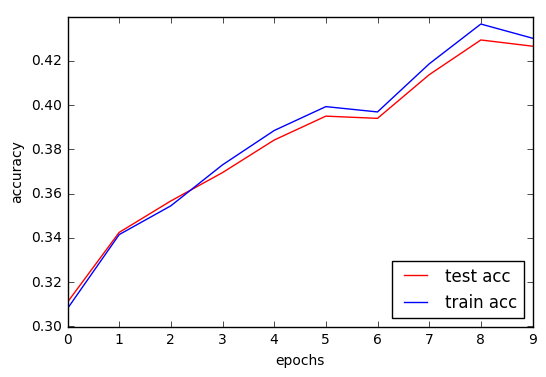

In [4]:
# for repeatability
np.random.seed(0)

# Inputs
inp = edf.Value()
lab = edf.Value()


prev_channel = 3 # RGB channel 
########################## Simple Convolution Nerual Network Model for Cifar 10 ##################################
##################################################################################################################
# please implement your main cnn model here, as described by the homework, you can mimic the previous code
k1 = edf.Param(edf.xavier((3,3,3,32)))
k2 = edf.Param(edf.xavier((3,3,32,64)))
k3 = edf.Param(edf.xavier((1,1,64,10)))
b1 = edf.Param(np.zeros(32))
b2 = edf.Param(np.zeros(64))
b3 = edf.Param(np.zeros(10))

Con1 = Conv(inp,k1,stride=1,pad=1)
Add1 = edf.Add(Con1,b1)
Relu1 = edf.RELU(Add1)
Max1 = MaxPool(Relu1,ksz=4,stride=4)

Con2 = Conv(Max1,k2,stride=1,pad=0)
Add2 = edf.Add(Con2,b2)
Relu2 = edf.RELU(Add2)
Avg1 = AvePool(Relu2,ksz=6,stride=6)

Conv3 = Conv(Avg1,k3,stride=1,pad=0)
Add3 = edf.Add(Conv3,b3)
Relu3 = edf.RELU(Add3)
pred = edf.Reshape(Relu3,(-1,10))

# the standard classification layer, which you don't need to modify
pred = edf.SoftMax(pred)
loss = edf.Mean(edf.LogLoss(edf.Aref(pred,lab)))
acc = edf.Accuracy(pred,lab)

print("Entering Evaluation")
##################I Changed bucket to 5 for debugging ############
################################################################################################################## 
# evaluation bucket
bucket = 100
def eval_train():    
    
    # we only choose 1/5 of the train images for evaluation since evaluation the whole images is time consuming
    eval_imgs = t_imgs[::5]
    eval_labels = t_labels[::5]
    avg_acc = 0
    avg_loss = 0
    
    for seq in range(bucket):
        inp.set(eval_imgs[seq::bucket])
        lab.set(eval_labels[seq::bucket])
        edf.Forward()
        avg_acc += acc.value
        avg_loss += loss.value
    
    return avg_acc/bucket, avg_loss/bucket
        
def eval_test():
    
    avg_acc = 0
    avg_loss = 0
    for seq in range(bucket):
        inp.set(v_imgs[seq::bucket])
        lab.set(v_labels[seq::bucket])
        edf.Forward()
        avg_acc += acc.value
        avg_loss += loss.value
        #print(seq)
    return avg_acc/bucket, avg_loss/bucket

# initial accuracy 
#print("Entering eval_test")
#random_acc, random_loss = eval_test()
#print("Random test loss = %.4f, accuracy = %.4f" % (random_loss, random_acc))

################################################# train loop ######################################################
ep = 0
epoch = 10
batch = 100
train_loss = []; train_acc = []; test_loss =[]; test_acc = []
stime = time()
batches = range(0, len(t_labels), batch)
print("Entering Train")
while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))

    for k in batches:
        inp.set(t_imgs[perm[k:k+batch]])
        lab.set(t_labels[perm[k:k+batch]])
        edf.Forward()
        #print("forward")
        edf.Backward(loss)
        #print("backward")
        edf.Adam()
        #print("adam")
        if k%10000 == 0 : print(k)
    # evaluate on trainset
    t_acc, t_loss = eval_train()
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, t_loss,time()-stime))
    train_loss.append(t_loss)
    train_acc.append(t_acc)

    # evaluate on testset
    v_acc, v_loss = eval_test()
    print("test accuracy = %.4f" % v_acc)
    test_loss.append(v_loss)
    test_acc.append(v_acc)
    stime = time()
    ep += 1      

# plot
plt.figure(1)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(len(test_loss)), test_loss, color='red')
plt.plot(np.arange(len(train_loss)), train_loss, color='blue')
plt.legend(['test loss', 'train loss'], loc='upper right')
plt.show()

plt.figure(2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, color='red')
plt.plot(np.arange(len(train_acc)), train_acc, color='blue')
plt.legend(['test acc', 'train acc'], loc='lower right')
plt.show()